In [1]:
import xupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt 

from ekarus.e2e.cascading_stage_ao_class import CascadingAO
# from ekarus.e2e.single_stage_ao_class import SingleStageAO

from ekarus.e2e.utils import my_fits_package as myfits
from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid

import os.path as op


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
from arte.utils.zernike_generator import ZernikeGenerator
from arte.types.mask import CircularMask

def define_zernike_basis(mask, max_radial_order:int):

    N = (max_radial_order+1)*(max_radial_order+2)//2-1
    circ_mask = CircularMask(mask.shape, maskRadius=max(mask.shape)//2)
    zg = ZernikeGenerator(circ_mask)
    zern_mat = xp.zeros([N,int(xp.sum(1-mask))])
    for i in range(N):
        noll = i+2
        zern = xp.asarray(zg.getZernike(noll))
        zern_mat[i,:] = zern[~mask]

    return zern_mat

In [3]:
prf = 'mag7_'
cascao = CascadingAO(tn='cascading_8m_Mic')
ma_atmo_phases, _, res1_phases, det1_frames, rec1_modes, dm1_cmds, _, res2_phases, det2_frames, rec2_modes, dm2_cmds = cascao.load_telemetry_data(save_prefix=prf)
KL1 = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_KL.fits'))
KL2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_KL.fits'))

Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps


In [4]:
# # Define Zernike basis (and inverse)
# zern_mat = define_zernike_basis(cascao.cmask,max_radial_order=69)
# zern_inv = xp.linalg.pinv(zern_mat)

# print(zern_mat.shape, zern_inv.shape)

In [5]:
# N = 40
# mat = xp.zeros([N**2,int(xp.sum(1-mask))])
# ma_cosX = xp.zeros([N,int(xp.sum(1-mask))])
# ma_cosY = xp.zeros([N,int(xp.sum(1-mask))])

# for i in range(N):
#     cosX = xp.cos(i*xp.pi*X/(max(X)-min(X)))
#     cosX_2d = reshape_on_mask(cosX, mask)
#     ma_cosX[i,:] = cosX_2d[~mask]
#     cosY = xp.cos(i*xp.pi*Y/(max(Y)-min(Y)))
#     cosY_2d = reshape_on_mask(cosY, mask)
#     ma_cosY[i,:] = cosY_2d[~mask]


# for i in range(N):
#     for j in range(N):
#         mat[j+i*N,:] = ma_cosX[i,:] * ma_cosY[j,:]

In [6]:
def define_fourier_basis(mask, max_freq:int, thr:float=5e-2):
    """
    Build a real Fourier modal basis sampled on the valid pixels inside `mask`.
    - mask: boolean array where True = masked/outside pupil (same convention as notebook).
    - max_freq: maximum integer spatial frequency in each axis (frequencies range -max_freq..max_freq).
    - orthonormalize: if True, attempt to orthonormalize the modes (QR on the sampling matrix).
    - use_cos_sin: if True produce separate cos and sin components (real basis).
    Returns:
    - fourier_mat: xp.array shape (n_modes, n_valid_pixels)
    """
    X, Y = image_grid(mask.shape, recenter=True)
    Xv = X[~mask]/(xp.max(X)-xp.min(X))
    Yv = Y[~mask]/(xp.max(Y)-xp.min(Y))
    freqs = xp.arange(max_freq, dtype=int)
    modes = []
    for fx in freqs:
        for fy in freqs:
            if fx == 0 and fy == 0:
                continue
            arg = xp.pi * (fx * Xv + fy * Yv)
            modes.append(xp.cos(arg))
            modes.append(xp.sin(arg))
    fourier_mat = xp.vstack(modes)  # shape (n_modes, M)

    # remove near-duplicate / zero-energy rows (numerical safety)
    norms = xp.linalg.norm(fourier_mat, axis=1)
    keep = norms > (thr * xp.max(norms))
    fourier_mat = fourier_mat[keep, :]

    return fourier_mat

In [7]:
# _epsilon = 1e-12
# def make_fourier_basis(coordinates, frequencies, sort_by_energy=True):
#     '''Make a Fourier basis.
#     '''
#     modes_cos = []
#     modes_sin = []
#     energies = []
#     ignore_list = []

#     for i, freq in enumerate(frequencies):
#         if i in ignore_list:
#             continue

#         mode_cos = xp.cos(xp.dot(freq, coordinates))
#         mode_sin = xp.sin(xp.dot(freq, coordinates))

#         modes_cos.append(mode_cos)
#         modes_sin.append(mode_sin)

#         j = xp.argmin(frequencies+freq)

#         dist = frequencies[j] + freq
#         dist2 = xp.dot(dist, dist)

#         p_length2 = xp.dot(freq, freq)
#         energies.append(p_length2)

#         if dist2 < (_epsilon * p_length2):
#             ignore_list.append(j)

#     energies = xp.array(energies)
#     if sort_by_energy:
#         ind = xp.argsort(energies)
#         modes_sin = [modes_sin[int(i)] for i in ind]
#         modes_cos = [modes_cos[int(i)] for i in ind]
#         energies = xp.array(energies)[ind]

#     modes = []
#     for i, E in enumerate(energies):
#         # Filter out and correctly normalize zero energy vs non-zero energy modes.
#         if E > _epsilon:
#             modes.append(modes_cos[i] * xp.sqrt(2))
#             modes.append(modes_sin[i] * xp.sqrt(2))
    #     else:
    #         modes.append(modes_cos[i])

    # return xp.array(modes)

In [8]:
x,y = cascao.dm1.act_coords

IFs = cascao.dm1.IFF.copy()
Rec = xp.linalg.pinv(IFs)

mask = cascao.dm1.mask.copy()
X,Y = image_grid(mask.shape,recenter=True)
X = X[~mask]
Y = Y[~mask]

# N = 64
# M = int(xp.sum(1-mask))
# s = xp.pi / (xp.max(X) - xp.min(X))
# idx = xp.arange(N, dtype=int)[:, None] 
# ma_cosX = xp.cos(idx * s * X[None, :])
# ma_cosY = xp.cos(idx * s * Y[None, :])
# # build full basis by broadcasting: result shape (N, N, M) -> reshape to (N*N, M)",
# fourier_mat = (ma_cosX[:, None, :] * ma_cosY[None, :, :]).reshape(N*N, M)
# # optional: free temporary arrays",
# del ma_cosX, ma_cosY

# fourier_inv = xp.linalg.pinv(fourier_mat)

In [9]:
fourier_mat = define_fourier_basis(mask, max_freq=64)

(8190, 12849)


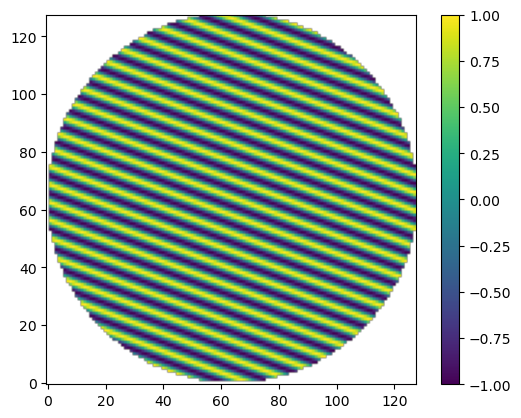

In [10]:
print(fourier_mat.shape)
plt.figure()
plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(fourier_mat[2000,:],mask)),xp.asnumpy(mask)),origin='lower')
plt.colorbar()

In [ ]:
# def project_on_dm_modes(modal_base, iffs):
#     n_pix, n_acts = xp.shape(iffs)
#     n_modes, n_pix = xp.shape(modal_base)

#     filtered_iffs = iffs.copy()

#     coeffs = xp.linalg.pinv(iffs) @ modal_base
#     fit_modes = iffs @ coeffs

#     mode_norms = xp.sum(fit_modes @ fit_modes.T, axis=0)

#     for mode_id in xp.arange(n_modes):
#         mode = fit_modes[mode_id,:]
#         mode_norm = xp.sum(mode * mode)

#         if mode_norm > 0:
#             for act_id in xp.arange(n_acts):
#                 coef[mode_id, act_id] = xp.sum(filtered_iffs[act_id, :] * mode) / mode_norm
#                 filtered_iffs[act_id, :] -= mode * coef[mode_id, act_id]





In [11]:
# fourier_mat2 = make_fourier_basis(xp.vstack([X,Y]), frequencies=xp.linspace(0.1,10,num=100,endpoint=True))
# print(fourier_mat2.shape)

# plt.figure()
# plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(fourier_mat2[19,1,:],mask)),xp.asnumpy(mask)),origin='lower')
# plt.colorbar()

# plt.figure()
# plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(fourier_mat2[10,1,:],mask)),xp.asnumpy(mask)),origin='lower')
# plt.colorbar()

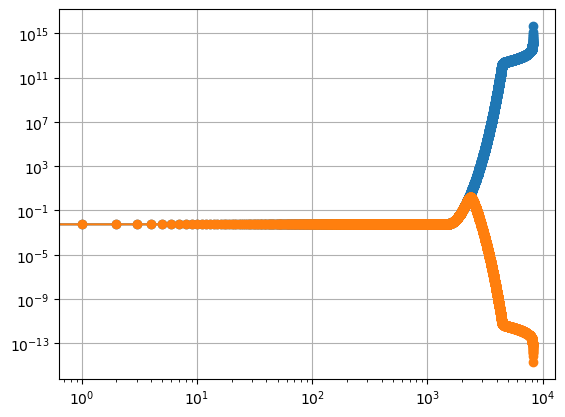

In [12]:
U,D,V = xp.linalg.svd(fourier_mat.T, full_matrices=False)
gamma = 0.1
Dinv = D / (D**2 + gamma * (D/max(D)<=gamma))
fourier_inv = (V.T * Dinv) @ U.T

del U,V

plt.figure()
plt.plot(xp.asnumpy(1/D),'-o')
plt.plot(xp.asnumpy(Dinv),'-o')
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [13]:

# KL2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_KLmodes.fits'))
# phase2modes = xp.linalg.pinv(KL.T)

# def get_modes(ma,id):
#     im_data = ma[id].data
#     phase = xp.array(im_data[~ma[id].mask])
#     ph_rms = xp.sqrt(xp.sum(phase**2)/len(phase))
#     modes = phase2modes @ phase
#     rec_phase = KL.T @ modes
#     rec_phase_2d = reshape_on_mask(rec_phase, xp.asarray(ma[id].mask))
#     rec_ma = masked_array(xp.asnumpy(rec_phase_2d), ma[id].mask)
#     return modes, rec_ma, ph_rms

In [14]:
# atmo_modes, rec_atmo, atmo_rms = get_modes(ma_atmo_phases,-1)
# res1_modes, rec_ph1, res1_rms = get_modes(res1_phases,-1)
# res2_modes, rec_ph2, res2_rms = get_modes(res2_phases,-1)

# print(xp.sum(xp.abs(atmo_modes)),xp.sum(xp.abs(res1_modes)),xp.sum(xp.abs(res2_modes)))
# print(xp.sum(xp.abs(atmo_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res1_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res2_modes)*xp.std(KL.T,axis=0)))
# print(atmo_rms, res1_rms, res2_rms)

In [15]:
# mask = cascao.cmask.copy()
# # m2c1 = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_m2c.fits'))
# # m2c2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_m2c.fits'))

# # c2m1 = xp.linalg.pinv(m2c1[:rec1_modes.shape[1],:])
# # c2m2 = xp.linalg.pinv(m2c2[:rec2_modes.shape[1],:])

# # rec1_kls = c2m1 @ rec1_modes[-1]
# rec1_phase = KL[:rec1_modes.shape[1],:].T @ rec1_modes[-1]
# rec1_phase_2d = reshape_on_mask(rec1_phase, mask)
# rec1_ma = masked_array(xp.asnumpy(rec1_phase_2d), xp.asnumpy(mask))
# # rec2_kls = c2m2 @ rec2_modes[-1]
# rec2_phase = KL2[:rec2_modes.shape[1],:].T @ rec2_modes[-1]
# rec2_phase_2d = reshape_on_mask(rec2_phase, mask)
# rec2_ma = masked_array(xp.asnumpy(rec2_phase_2d), xp.asnumpy(mask))

In [16]:
# plt.figure(figsize=(16,12))
# plt.subplot(3,3,1)
# plot_masked_array(ma_atmo_phases,-1)
# plt.subplot(3,3,2)
# plot_masked_array(res1_phases,-1)
# plt.subplot(3,3,3)
# plot_masked_array(res2_phases,-1)
# plt.subplot(3,3,4)
# plot_masked_array(rec_atmo)
# plt.subplot(3,3,5)
# plot_masked_array(rec_ph1)
# plt.subplot(3,3,6)
# plot_masked_array(rec_ph2)
# plt.subplot(3,3,8)
# plot_masked_array(rec1_ma)
# plt.subplot(3,3,9)
# plot_masked_array(rec2_ma)

In [17]:
def plot_masked_array(ma, id=None, mask=None):
    if mask is not None:
        img = reshape_on_mask(ma[id],mask)
        marray = masked_array(xp.asnumpy(img), xp.asnumpy(mask))
    else:
        ma_id = ma.copy()
        if id is not None:
            ma_id = ma[id]
        marray = masked_array(ma_id.data,mask=ma_id.mask)
    plt.imshow(marray,origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.axis('off')


def filter_modes(atmo_phases, KL, nModes2Filter=None, coeff=1.0):
    if nModes2Filter is not None:
        MM = KL[:nModes2Filter,:].T
    else:
        MM = (KL.T).copy()
    phase2modes = xp.linalg.pinv(MM)
    modes = phase2modes @ atmo_phases.T
    rec_phases = MM @ modes
    rec_phases *= coeff
    filt_phases = atmo_phases.T - rec_phases
    return filt_phases.T


def masked_array_to_matrix(ma_vec, mask):
    N = xp.shape(ma_vec)[0]
    data_len = int(xp.sum(1-mask))
    mat = xp.zeros([N,data_len])
    for i in range(N):
        mat[i,:] = xp.asarray(ma_vec[i].data)[~mask]
    return mat

In [18]:
def simulate_cascading_performance(atmo_phases, nModes_1st_stage:int, correction_1st_stage:float, 
                                   nModes_2nd_stage:int, correction_2nd_stage:float,
                                   normalize_to_perfect_psf:bool = True, modes=None, 
                                   lambdaRef:float=750e-9, Nframes:int=128, use_avg_field:bool=True,
                                   ):
    
    if modes is not None:
        MM1 = modes.copy()
        MM2 = modes.copy()
    else:
        MM1 = KL1.copy()
        MM2 = KL2.copy()
    filt_phases_1st_stage = filter_modes(atmo_phases, MM1, nModes_1st_stage, coeff=correction_1st_stage)
    filt_phases_2nd_stage = filter_modes(filt_phases_1st_stage, MM2, nModes_2nd_stage, coeff=(1-(1-correction_2nd_stage)/(1-correction_1st_stage)))
    filt_phases_perfect_stage = filter_modes(atmo_phases, MM1, max(nModes_1st_stage,nModes_2nd_stage))

    atmo_phases_in_rad = atmo_phases[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_1st_in_rad = filt_phases_1st_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_2nd_in_rad = filt_phases_2nd_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_perf_in_rad = filt_phases_perfect_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef

    _, atmo_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, stage1_profile, pix_dist = cascao.get_contrast(filt_1st_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, stage2_profile, pix_dist = cascao.get_contrast(filt_2nd_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, perf_stage_profile, pix_dist = cascao.get_contrast(filt_perf_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

    plt.figure()
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(atmo_profile), label='atmo')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(stage1_profile), label=f'1st stage: {nModes_1st_stage:1.0f} modes @ {correction_1st_stage*1e+2:1.0f}%')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(stage2_profile), label=f'2nd stage: {nModes_2nd_stage:1.0f} modes @ {correction_2nd_stage*1e+2:1.1f}%')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(perf_stage_profile), label=f'perfect stage: {nModes_1st_stage:1.0f} modes @ 100%')
    plt.legend()
    plt.grid()
    plt.xlim([0,24])
    plt.ylim([1e-7,1e-2])
    plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
    plt.xlabel(r'$\lambda/D$')
    plt.yscale('log')
    plt.title('Contrast with perfect coronograph\nand partial correction')

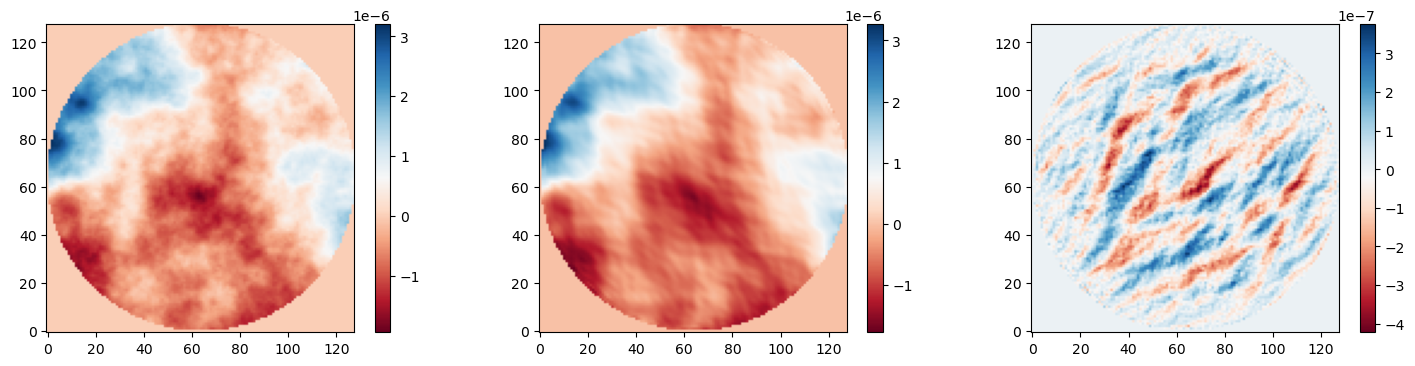

In [19]:
atmo_phases = masked_array_to_matrix(ma_atmo_phases, cascao.cmask)
atmo_phase = atmo_phases[0,:]
rec_phase = fourier_inv @ atmo_phase
# rec_phase = (rec_mode * D) @ U.T
rec_phase =  fourier_mat.T @ rec_phase
mask = cascao.cmask.copy()


plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase,mask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(reshape_on_mask(rec_phase,mask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase-rec_phase,mask)),origin='lower',cmap='RdBu')
plt.colorbar()

In [20]:
# atmo_phases = masked_array_to_matrix(ma_atmo_phases, cascao.cmask)
# # simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=400, correction_1st_stage=0.95, nModes_2nd_stage=100, correction_2nd_stage=0.995)
# atmo_phase = atmo_phases[0,:]

# rec_mode = zern_mat @ atmo_phase
# rec_phase = zern_inv @ rec_mode
# mask = cascao.cmask.copy()


# plt.figure(figsize=(18,4))
# plt.subplot(1,3,1)
# plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.subplot(1,3,2)
# plt.imshow(xp.asnumpy(reshape_on_mask(rec_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.subplot(1,3,3)
# plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase-rec_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()

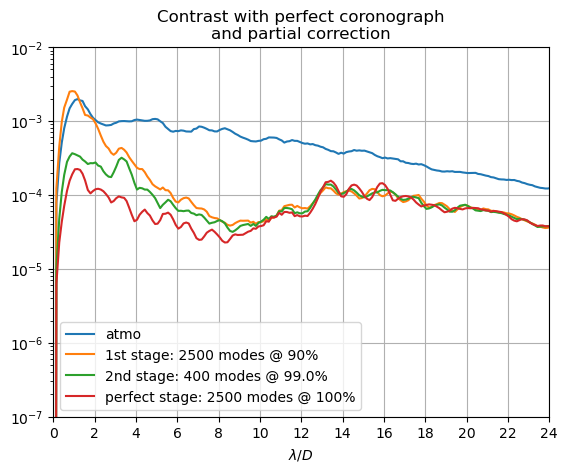

In [21]:
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=2500, correction_1st_stage=0.9, nModes_2nd_stage=400, correction_2nd_stage=0.99, modes=fourier_inv[:2500,:])

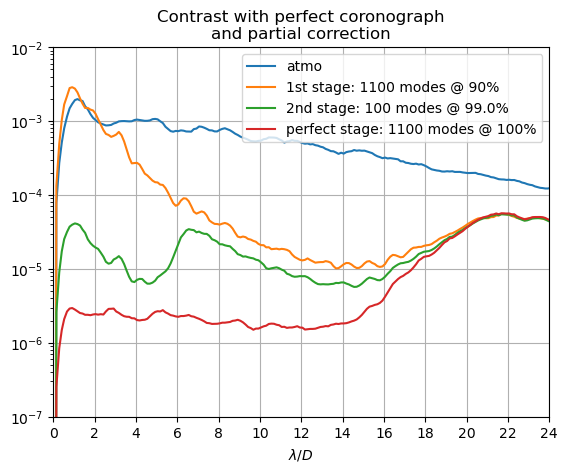

In [22]:
# atmo_phases = masked_array_to_matrix(ma_atmo_phases, cascao.cmask)
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=1100, correction_1st_stage=0.9, nModes_2nd_stage=100, correction_2nd_stage=0.99)

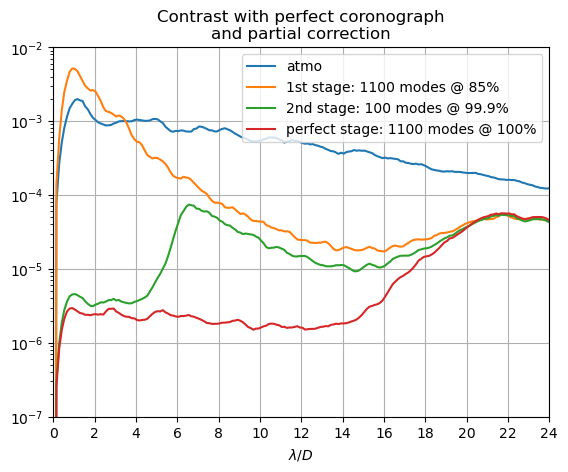

In [23]:
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=1100, correction_1st_stage=0.85, nModes_2nd_stage=100, correction_2nd_stage=0.999)

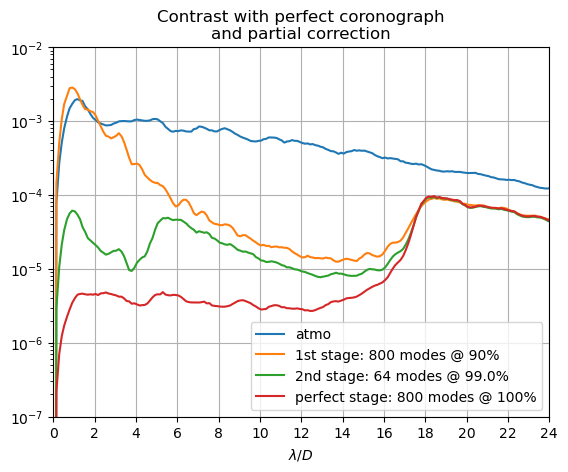

In [24]:
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=800, correction_1st_stage=0.9, nModes_2nd_stage=64, correction_2nd_stage=0.99)

In [25]:
lambdaRef = 750e-9
N = 128

filt1100_phases = filter_modes(atmo_phases, KL1, 1100)
atmo_phases_in_rad = atmo_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt1100_phases_in_rad = filt1100_phases[-N:,:] * (2*xp.pi)/lambdaRef

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8)

In [26]:
# ssao = SingleStageAO(tn='cascading_8m_ssao_ref')
# psf1, pix_dist = ssao.plot_contrast(lambdaRef, frame_ids=xp.arange(ssao.Nits-128,ssao.Nits).tolist(), save_prefix='f1kHz_', oversampling=8)
# psf2, pix_dist = ssao.plot_contrast(lambdaRef, frame_ids=xp.arange(ssao.Nits-128,ssao.Nits).tolist(), save_prefix='f4kHz_', oversampling=8)
# plt.figure()
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='seeing limited')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(psf1), label='baseline (1 kHz correction)')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(psf2), label='goal (4 kHz correction)')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='ideal (perfect correction)')
# plt.legend()
# plt.grid()
# plt.xlim([0,24])
# plt.ylim([1e-7,1e-2])
# plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
# plt.xlabel(r'$\lambda/D$')
# plt.yscale('log')
# plt.title('Contrast @ 750nm\nSingle stage, perfect coronograph')

In [27]:

# atmo_noTT_phases = filter_modes(atmo_phases, KL1, 2)
filt10_phases = filter_modes(atmo_phases, KL1, 10)
filt100_phases = filter_modes(atmo_phases, KL1, 100)
filt200_phases = filter_modes(atmo_phases, KL1, 200)
filt800_phases = filter_modes(atmo_phases, KL1, 800)

In [28]:

# filt5_phases_in_rad = filt5_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt10_phases_in_rad = filt10_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt100_phases_in_rad = filt100_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt200_phases_in_rad = filt200_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt800_phases_in_rad = filt800_phases[-N:,:] * (2*xp.pi)/lambdaRef

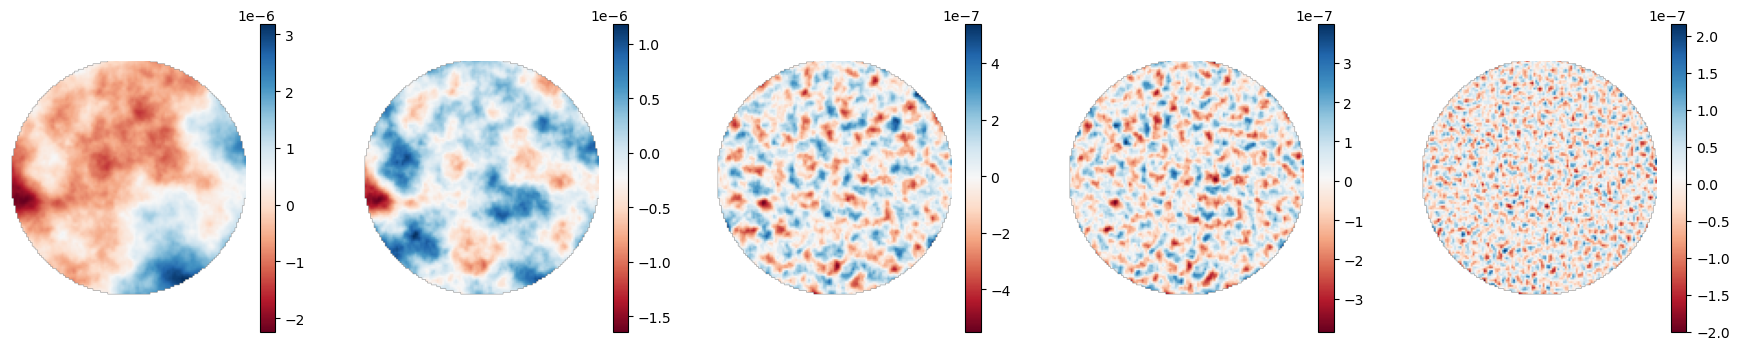

In [29]:
plt.figure(figsize=(22,4))
plt.subplot(1,5,1)
plot_masked_array(atmo_phases,-1, cascao.cmask)
plt.subplot(1,5,2)
plot_masked_array(filt10_phases,-1, cascao.cmask)
plt.subplot(1,5,3)
plot_masked_array(filt100_phases,-1, cascao.cmask)
plt.subplot(1,5,4)
plot_masked_array(filt200_phases,-1, cascao.cmask)
plt.subplot(1,5,5)
plot_masked_array(filt800_phases,-1, cascao.cmask)

In [ ]:
normalize_to_perfect_psf = True
use_avg_field = False

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

OutOfMemoryError: Out of memory allocating 1,073,741,824 bytes (allocated so far: 7,685,026,304 bytes).

: 

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

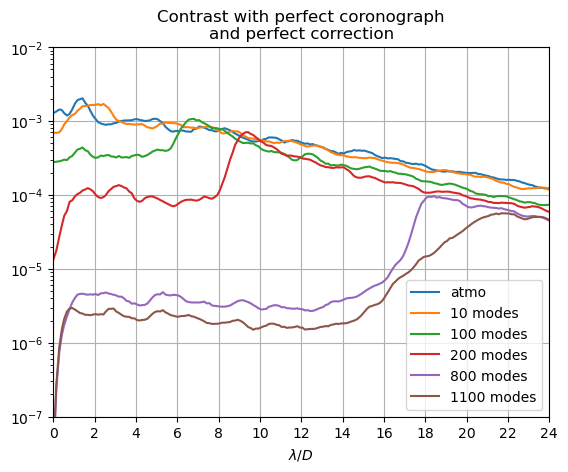

In [ ]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [ ]:
normalize_to_perfect_psf = True
use_avg_field = True

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

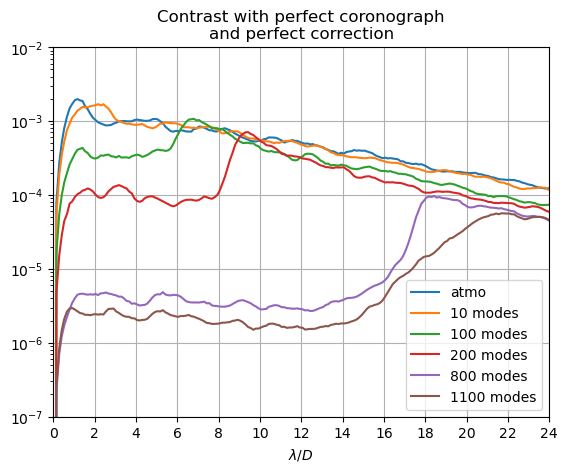

In [ ]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [ ]:
filt100_phases = filter_modes(atmo_phases, zern_inv.T, 100)
filt800_phases = filter_modes(atmo_phases, zern_inv.T, 800)
filt1100_phases = filter_modes(atmo_phases, zern_inv.T, 1100)
filt2000_phases = filter_modes(atmo_phases, zern_inv.T, 2000)

In [ ]:
filt100_phases_in_rad = filt100_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt800_phases_in_rad = filt800_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt1100_phases_in_rad = filt1100_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt2000_phases_in_rad = filt2000_phases[-N:,:] * (2*xp.pi)/lambdaRef

In [ ]:
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile2000, pix_dist = cascao.get_contrast(filt2000_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

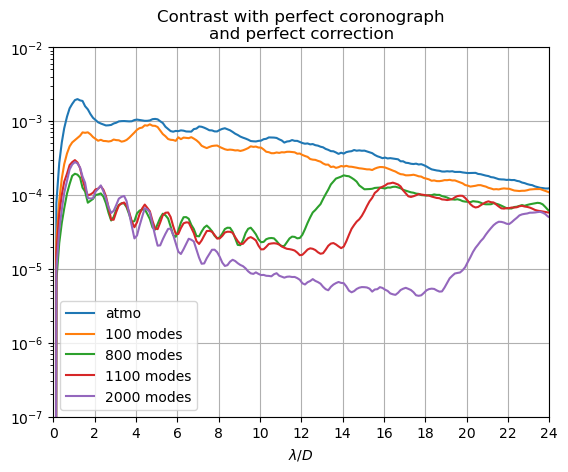

In [ ]:
plt.figure()#figsize=(16,5))
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile2000), label='2000 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')